In [9]:
import os
import pickle
import hashlib
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [10]:
## ********** data preprocessing functions **********

def load_data(data_filename):
  df1 = pd.read_csv(data_filename, sep='\t', index_col=0)
  print(df1.shape)
  nan_count = list(df1.isna().sum(axis=0))
  assert nan_count.count(0) == df1.shape[1]
  nan_count = list(df1.isna().sum(axis=1))
  assert nan_count.count(0) == df1.shape[0]
  feature_names = list(df1.index)[2:]
  print('# of features : ', len(feature_names))
  labels = np.array(df1.iloc[1])
  labels_to_y = {'Nunavik': 'Nunavik', 'NonWesternized': 'Non Westernized', 'Westernized': 'Westernized'}
  y = [labels_to_y[l] for l in labels]
  print('# of samples : ', len(y))
  df2 = df1.iloc[2:]
  print(df2.shape)
  X = df2.T
  return X, y, feature_names

def get_hash(e):
  # returns a hash value for a dataframe
  # used to ensure that the data is the same than in the original experiment run
  # idea from https://death.andgravity.com/stable-hashing
  assert isinstance(e, pd.DataFrame)
  json_dump = e.to_json(orient='split', date_format='epoch', double_precision=10, force_ascii=True, date_unit='ms', lines=False, index=True, indent=None)
  return hashlib.md5(json_dump.encode('utf-8')).digest().hex()


In [11]:
## ********** machine learning utils functions **********

dir = ''
splits_subdirectory = os.path.join(dir, 'splits')
results_subdirectory = os.path.join(dir, 'grid_search_results')

def generate_splits(X, y, n_splits, test_size, seed, dataset_name):
  if not os.path.exists(splits_subdirectory):
    os.makedirs(splits_subdirectory)
  for id in range(n_splits):
    random_state = seed + id
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    np.savez(os.path.join(splits_subdirectory, dataset_name+'_split_'+str(id)), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print('split {} saved in {}'.format(id, os.path.join(splits_subdirectory, dataset_name+'_split_'+str(id))))

def grid_search_on_split(split_id, classifier, hyperparameters_grid, dataset_name):
  X_train, X_test, y_train, y_test = load_split(split_id, dataset_name)
  grid = GridSearchCV(estimator=classifier, param_grid=hyperparameters_grid, verbose=1, n_jobs=4)
  grid_result = grid.fit(X_train, y_train)
  print('grid-Search done!\n')
  best_params = grid_result.best_params_
  save_best_params(best_params, split_id, dataset_name)
  print('best params:', best_params)
  results = pd.DataFrame(grid_result.cv_results_) # convert GS results to a pandas dataframe
  save_grid_search_results(results, split_id, dataset_name)

def load_split(split_id, dataset_name):
  split_filename = os.path.join(splits_subdirectory, dataset_name+'_split_{}.npz'.format(split_id))
  split = np.load(split_filename, allow_pickle=True)
  X_train, X_test = split['X_train'], split['X_test']
  y_train, y_test = split['y_train'], split['y_test']
  return X_train, X_test, y_train, y_test

def clean_splits_files(n_splits, dataset_name):
  for split_id in range(n_splits):
    split_filename = os.path.join(splits_subdirectory, dataset_name+'_split_{}.npz'.format(split_id))
    os.remove(split_filename)
  os.rmdir(splits_subdirectory)

def save_best_params(best_params, split_id, dataset_name):
  save_params_path = os.path.join(results_subdirectory, dataset_name+'_best_params_{}.pkl'.format(split_id))
  if not os.path.exists(results_subdirectory):
    os.makedirs(results_subdirectory)
  with open(save_params_path, 'wb') as f:
    pickle.dump(best_params, f)
  print('grid search best parameters for split {} saved in {}'.format(split_id, save_params_path))  

def load_best_params(split_id, dataset_name):
  best_params_filename = os.path.join(results_subdirectory, '{}_best_params_{}.pkl'.format(dataset_name, split_id))
  with open(best_params_filename, "rb") as f:
    best_params = pickle.load(f)
  return best_params

def save_grid_search_results(results, split_id, dataset_name):
  save_result_path = os.path.join(results_subdirectory, '{}_results_{}.csv'.format(dataset_name, split_id))
  if not os.path.exists(results_subdirectory):
    os.makedirs(results_subdirectory)
  results.to_csv(save_result_path)
  print('grid search results for split {} saved in {}.csv'.format(split_id, save_result_path))  

def load_grid_search_results(split_id, dataset_name):
  results_filename = os.path.join(results_subdirectory,'{}_results_{}.csv'.format(dataset_name, split_id))
  best_params = pd.read_csv(results_filename)
  return best_params

In [15]:
## ********** results vizualisation functions **********

def evaluate_predictions(y_test, pred):
  print('random_forest accuracy: ', round(accuracy_score(y_test, pred), 3))
  print('random_forest balanced_accuracy_score: ', round(balanced_accuracy_score(y_test, pred), 3))
  print('random_forest matthews_correlation coefficient: ', round(matthews_corrcoef(y_test, pred), 3))
  conf_labels = ['Westernized', 'Nunavik', 'Non Westernized']
  conf = confusion_matrix(y_test, pred, labels=conf_labels)
  confusion = conf/conf.sum()
  print('\n\n      # random forest confusion matrix :')
  print('                                              predicted values')
  print('                                  {}    |      {}     |  {}  | '.format(conf_labels[0], conf_labels[1], conf_labels[2]))
  print('                                ---------------------------------------------------------')
  print('   true     {}       |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Westernized', confusion[0,0], confusion[0,1], confusion[0,2]))
  print('  values                        ---------------------------------------------------------')
  print('            {}           |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Nunavik', confusion[1,0], confusion[1,1], confusion[1,2]))
  print('                                ---------------------------------------------------------')
  print('            {}   |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Non Westernized', confusion[2,0], confusion[2,1], confusion[2,2]))
  print('                                ---------------------------------------------------------')

def display_top_features(all_feature_importance_df, n_top_feat):
  all_feature_importance_dict = {feat: list(all_feature_importance_df[feat]) for feat in list(all_feature_importance_df)}
  #result_avg_importance = {features_names[i] : sum(all_features_importance[i])/len(all_features_importance[i]) for i in range(len(features_names))}
  #result_sorted = {k: v for k, v in sorted(result_avg_importance.items(), key=lambda item: item[1], reverse=True)}
  result_median_importance = {feat_name : statistics.median(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_average_importance = {feat_name : statistics.mean(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_pstdev_importance = {feat_name : statistics.pstdev(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_sorted = {k: v for k, v in sorted(result_median_importance.items(), key=lambda item: item[1], reverse=True)}
  rank = 0
  box_plot_dict = {'Feature name': [], 'Median Gini importance': []}
  print('  rank    feature {:55s}     '.format(''), 'median importance      average      standard-deviation')
  for k in result_sorted:
    rank += 1
    if rank <= n_top_feat:
      display_line = '  {:3d}     {:65s}         {:6.6f}          {:6.6f}         {:6.6f}'.format(rank, k, result_sorted[k], result_average_importance[k], result_pstdev_importance[k])
      print(display_line)
      box_plot_dict['Feature name'] = box_plot_dict['Feature name'] + [' ({}) {}'.format(k,str(rank))]*len(all_feature_importance_dict[k])
      box_plot_dict['Median Gini importance'] = box_plot_dict['Median Gini importance'] + all_feature_importance_dict[k]
  return pd.DataFrame(box_plot_dict)

In [13]:
## ********** running experiments **********

## ***** load data and metadata *****
data_filename = 'joined_pathAbundance_cpm_Meta_Graham.csv'
dataset_name = 'functions'


X, y, feature_names = load_data(data_filename)
# ensure that the data file is the same than in original experiment run :
#assert get_hash(X) == 'a5ecdfd7c2e82e3512c7acea82c57f49'

print('X.shape', X.shape)

print('classes:', list(dict.fromkeys(y)))

print('# of samples:', X.shape[0])
print('# of features:', X.shape[1])
assert np.array_equal(X.shape[0], len(y))

## ***** generate splits of the data matrix *****
n_splits = 100
test_size = 0.3
seed = 1
splits_hashcode = generate_splits(X, y, n_splits, test_size, seed, dataset_name)

## ***** grid search tuning on splits *****
random_forest_n_estims = [1, 10, 100, 1000]
random_forest_param_grid = {'n_estimators' : random_forest_n_estims}
for split_id in range(n_splits):
  classifier = RandomForestClassifier(random_state=1)
  grid_search_on_split(split_id, classifier, random_forest_param_grid, dataset_name)

## ***** compute classifiers average performances and features importances *****
all_pred, all_y_test = [], []
sum_imp = []

for split_id in range(n_splits):
  print('split', split_id)
  X_train, X_test, y_train, y_test = load_split(split_id, dataset_name)
  classifier = RandomForestClassifier(random_state=1) #define classifier
  best_params = load_best_params(split_id, dataset_name)
  classifier.set_params(**best_params)
  print('best params:', best_params)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  all_pred.extend(y_pred)
  print('len(all_pred)', len(all_pred))
  all_y_test.extend(y_test)
  features_importance = classifier.feature_importances_
  assert len(features_importance) == X.shape[1] == len(feature_names)
  sum_imp.append(features_importance.sum())
  if split_id == 0:
    all_imp = [[imp] for imp in features_importance]
  else:
    for j in range(len(features_importance)):
      all_imp[j].append(features_importance[j])
  results_all_imp = pd.DataFrame({feature_names[i] : all_imp[i] for i in range(len(feature_names))})
  results_all_imp.to_csv(dataset_name+'_results_feature_importances.csv')

/tmp/ipykernel_29740/85475614.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

(26565, 456)
# of features :  26563
# of samples :  456
(26563, 456)
X.shape (456, 26563)
classes: ['Nunavik', 'Non Westernized', 'Westernized']
# of samples: 456
# of features: 26563
split 0 saved in splits/functions_split_0
split 1 saved in splits/functions_split_1
split 0
best params: {'n_estimators': 1000}
len(all_pred) 137
split 1
best params: {'n_estimators': 1000}
len(all_pred) 274


random_forest accuracy:  0.909
random_forest balanced_accuracy_score:  0.888
random_forest matthews_correlation coefficient:  0.844


      # random forest confusion matrix :
                                              predicted values
                                  Westernized    |      Nunavik     |  Non Westernized  | 
                                ---------------------------------------------------------
   true     Westernized       |      0.1898      |      0.0839      |      0.0000       |
  values                        ---------------------------------------------------------
            Nunavik           |      0.0036      |      0.5730      |      0.0000       |
                                ---------------------------------------------------------
            Non Westernized   |      0.0000      |      0.0036      |      0.1460       |
                                ---------------------------------------------------------
  rank    feature                        

<AxesSubplot: xlabel='Median Gini importance', ylabel='Feature name'>

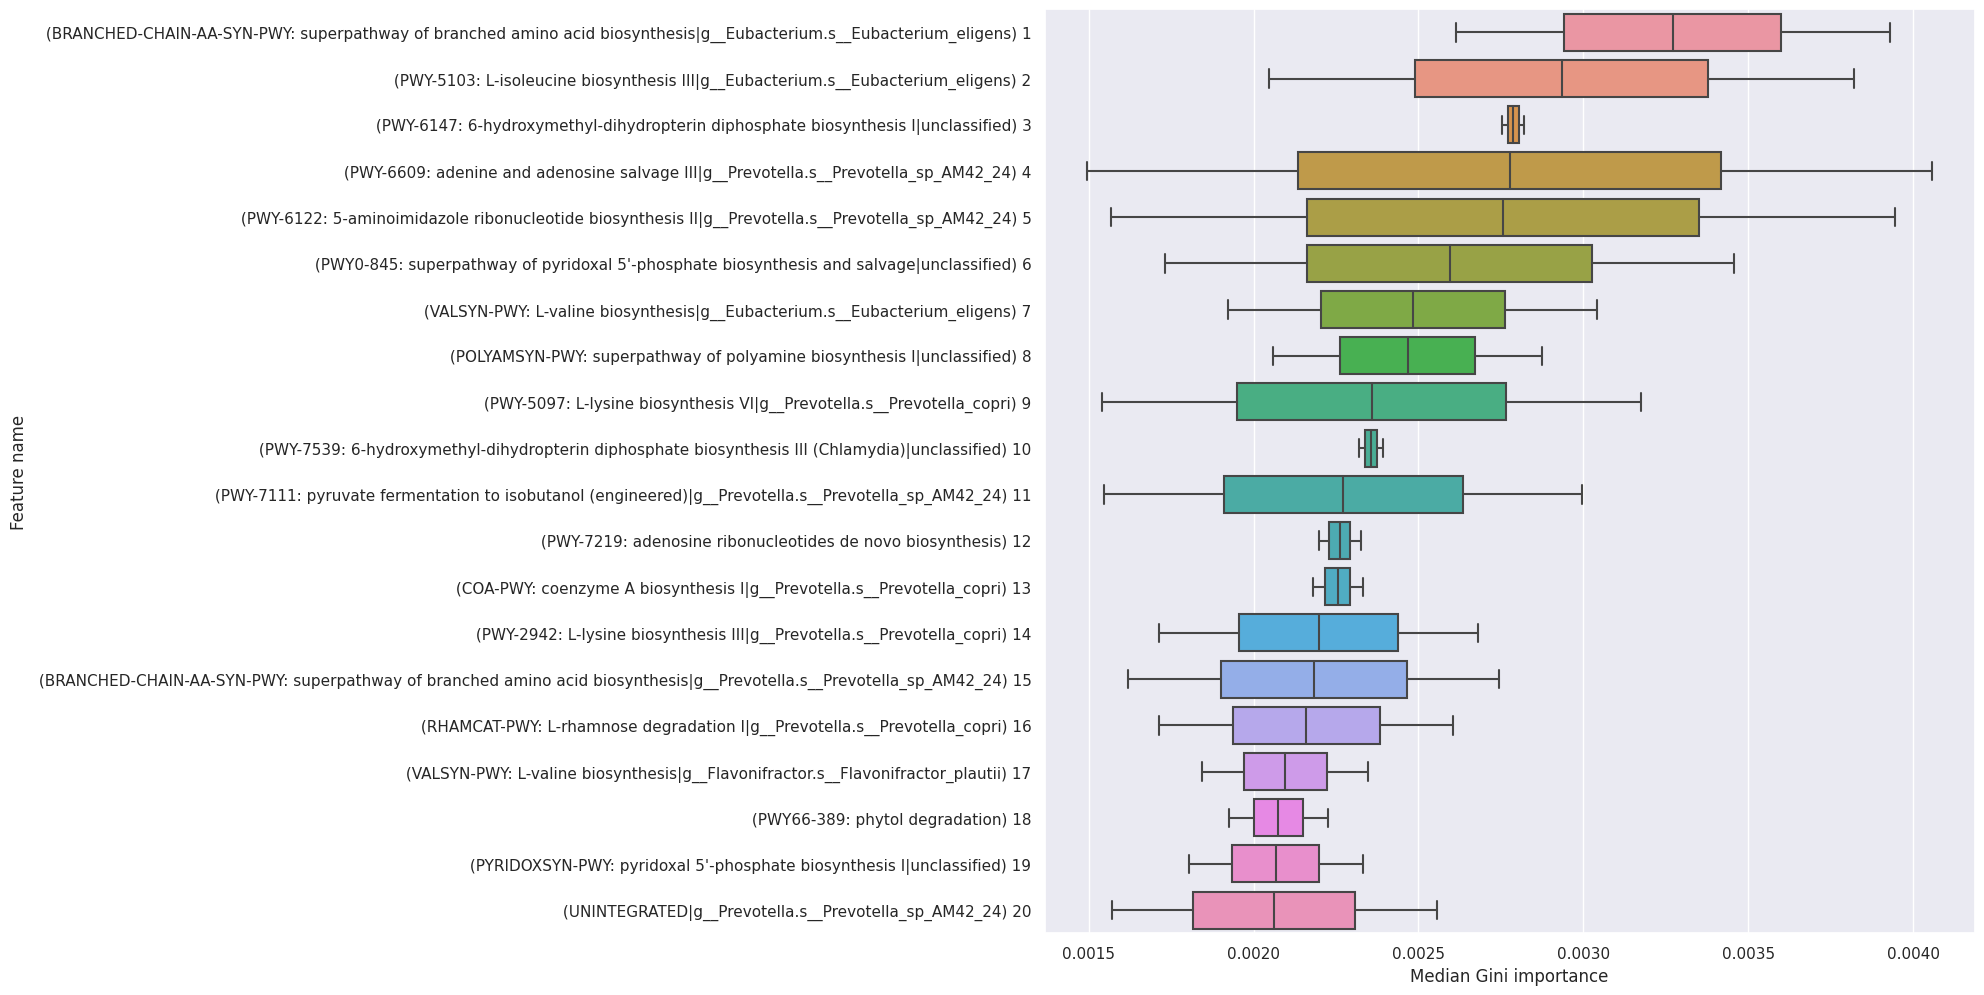

In [16]:
## ***** display results *****
evaluate_predictions(all_y_test, all_pred)

all_feature_importance_df = pd.read_csv(dataset_name+'_results_feature_importances.csv', index_col=0)
box_plot_df = display_top_features(all_feature_importance_df, 20)

sns.set(rc={'figure.figsize':(12,12)})
sns.boxplot(data=box_plot_df, x='Median Gini importance', y='Feature name')

In [19]:
#feature_names

print('SER-GLYSYN-PWY: superpathway of L-serine and glycine biosynthesisI|g__Eubacterium.s__Eubacterium_eligens_CAG_72')
print(feature_names[24542])
print('PWY-6737: starch degradationV|g__Ruthenibacterium.s__Ruthenibacterium_lactatiformans')
print(feature_names[17607])
print('TEICHOICACID-PWY: teichoic acid (polyglycerol) biosynthesis')
print(feature_names[24748])


SER-GLYSYN-PWY: superpathway of L-serine and glycine biosynthesisI|g__Eubacterium.s__Eubacterium_eligens_CAG_72
SER-GLYSYN-PWY: superpathway of L-serine and glycine biosynthesis I|g__Eubacterium.s__Eubacterium_eligens_CAG_72
PWY-6737: starch degradationV|g__Ruthenibacterium.s__Ruthenibacterium_lactatiformans
PWY-6737: starch degradation V|g__Ruthenibacterium.s__Ruthenibacterium_lactatiformans
TEICHOICACID-PWY: teichoic acid (polyglycerol) biosynthesis
TEICHOICACID-PWY: teichoic acid (poly-glycerol) biosynthesis


In [39]:
df = pd.read_csv(data_filename, sep=';', index_col=0)
df
feat = list(df.index)
feat

for w in wanted_features:
    if w in feat:
        print(w)

/tmp/ipykernel_15707/491016727.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

In [57]:
all_features = list(X)
all_features
#for f in all_features:
#    if f in wanted_features:
#        print(f)
#    elif f[:8] == 'BRANCHED':
#        print(f)

['1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis',
 '3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation',
 '7ALPHADEHYDROX-PWY: cholate degradation (bacteria, anaerobic)',
 'AEROBACTINSYN-PWY: aerobactin biosynthesis',
 'ALL-CHORISMATE-PWY: superpathway of chorismate metabolism',
 'ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast',
 'ANAEROFRUCAT-PWY: homolactic fermentation',
 'ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)',
 'ARG+POLYAMINE-SYN: superpathway of arginine and polyamine biosynthesis',
 'ARGDEG-PWY: superpathway of L-arginine, putrescine, and 4-aminobutanoate degradation',
 'ARGININE-SYN4-PWY: L-ornithine de novo  biosynthesis',
 'ARGORNPROST-PWY: arginine, ornithine and proline interconversion',
 'ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine)',
 'ARGSYNBSUB-PWY: L-arginine biosynthesis II (acetyl cycle)',
 'ARO-PWY: chorismate biosynthesis I',
 'ASPASN-PWY: superpathway of L-aspartate and L-asparagine biosynthesi

In [42]:
## ***** display results *****
box_plot_df = display_top_features(all_imp, features_names, 50)

sns.set(rc={'figure.figsize':(11,15)})
sns.boxplot(data=box_plot_df, x="importances", y="feature_name")

TypeError: display_top_features() missing 1 required positional argument: 'wanted_features'